In [932]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [933]:
# Загрузка данных
dfs = pd.read_csv("powerconsumption.csv",parse_dates=['Datetime'],nrows=15000)

dfs['Datetime'] = pd.to_datetime(dfs['Datetime'], format='%d/%m/%Y %H:%M')
data = dfs.drop(['Datetime'], axis=1)
data.index = dfs['Datetime']

# Вывод первых нескольких строк для проверки
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15000 entries, 2017-01-01 00:00:00 to 2017-04-15 03:50:00
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature             15000 non-null  float64
 1   Humidity                15000 non-null  float64
 2   WindSpeed               15000 non-null  float64
 3   GeneralDiffuseFlows     15000 non-null  float64
 4   DiffuseFlows            15000 non-null  float64
 5   PowerConsumption_Zone1  15000 non-null  float64
 6   PowerConsumption_Zone2  15000 non-null  float64
 7   PowerConsumption_Zone3  15000 non-null  float64
dtypes: float64(8)
memory usage: 1.0 MB


In [934]:
data.head()



,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
Datetime,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


In [935]:
df=data.copy()
# Функция для обработки выбросов с использованием межквартильного размаха (IQR)
def handle_outliers_iqr(data):
    # Вычисляем межквартильный размах для каждого столбца
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Определяем границы выбросов
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Заменяем значения за пределами границ выбросов на среднее значение столбца
    data_clipped = data.clip(lower=lower_bound, upper=upper_bound, axis=1)

    return data_clipped

# Обработка выбросов
df = handle_outliers_iqr(df)
df=df.resample('10T').ffill()
df

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
Datetime,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964
...,...,...,...,...,...,...,...,...
2017-04-15 03:10:00,13.740,86.7,0.073,0.037,0.100,23870.82885,13329.53157,15633.45455
2017-04-15 03:20:00,13.960,86.1,0.075,0.033,0.108,24094.03660,13402.85132,15621.81818
2017-04-15 03:30:00,13.740,85.3,0.076,0.026,0.063,24168.43918,13333.19756,15552.00000


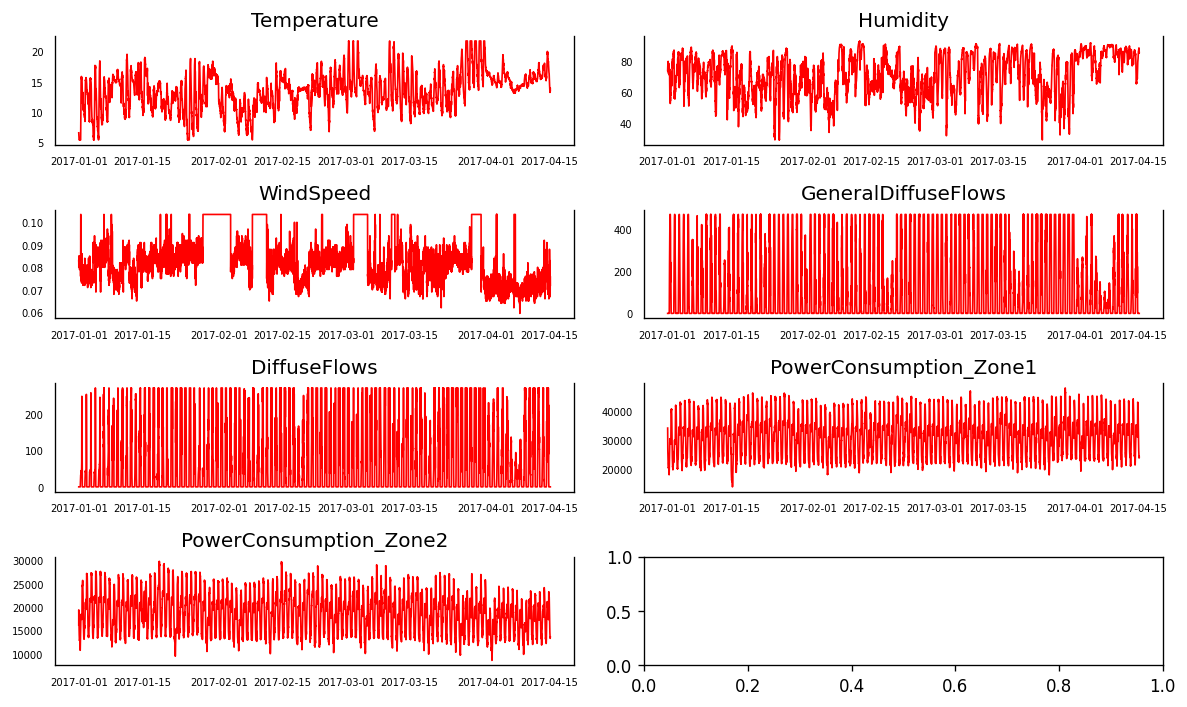

In [936]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()[:]):
    if (i == 7):
        continue
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [937]:
df.describe()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,13.589922,70.729179,0.083564,112.998028,64.882122,31082.108005,18633.850782,17511.344069
std,3.112812,13.294123,0.010343,167.792884,94.390544,6935.279744,4315.524406,4365.358617
min,5.395000,28.875000,0.059500,0.007000,0.033000,13895.696200,8560.081466,9348.387097
25%,11.500000,61.170000,0.076000,0.055000,0.126000,24333.559320,14604.255320,14451.337650
50%,13.770000,71.700000,0.082000,0.113000,0.208000,31692.151900,18878.939200,16400.080400
75%,15.570000,82.700000,0.087000,187.525000,108.500000,35307.574470,21581.762920,19388.806455
max,21.675000,92.900000,0.103500,468.730000,271.061000,47808.000000,29770.212770,26795.009662


In [938]:
# проверка на стационарность
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")


In [939]:
# разделяем выборку на обучающую и тестовую
split = 0.8
train = df[:int(split*(len(data)))]
test = df[int(split*(len(data))):]

In [940]:
for name, column in train.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Temperature" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -13.9046
 No. Lags Chosen       = 17
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Humidity" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.4903
 No. Lags Chosen       = 17
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "WindSpeed" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significa

In [941]:
# все ряды стационарны, создаем модель
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(train)

In [942]:
#Ищем лучший порядок модели
orders = [3,6,12,24,48,96,168,252,336]
AIC_min = 1
BIC_min = 1
FPE_min = 1
HQC_min = 1

results = [[],[],[],[]]
for i in orders:
    result = model.fit(i)
    results[0].append(result.aic)
    results[1].append(result.bic)
    results[2].append(result.fpe)
    results[3].append(result.hqic)

best_pos = [np.argmin(results[0]),np.argmin(results[1]),np.argmin(results[2]),np.argmin(results[3])]

for i,j in enumerate(zip(*results)):
    print('Lag Order =', orders[i])
    print('AIC : ', j[0], "*" if i == best_pos[0] else "")
    print('BIC : ', j[1], "*" if i == best_pos[1] else "")
    print('FPE : ', j[2], "*" if i == best_pos[2] else "")
    print('HQIC: ', j[3], "*" if i == best_pos[3] else "", '\n')

Lag Order = 3
AIC :  31.16744062908248 
BIC :  31.290678303459657 *
FPE :  34343733165098.33 
HQIC:  31.208781034795013  

Lag Order = 6
AIC :  31.108159887518873 
BIC :  31.349757972149654 
FPE :  32366991908771.125 
HQIC:  31.189205609109447  

Lag Order = 12
AIC :  31.023759064299856 
BIC :  31.502231642583702 
FPE :  29747371461172.824 
HQIC:  31.18426991476358 * 

Lag Order = 24
AIC :  31.015941438957675 
BIC :  31.96877869061913 
FPE :  29516299867098.375 
HQIC:  31.33560089799729  

Lag Order = 48
AIC :  31.06217442631431 
BIC :  32.96621174514861 
FPE :  30917788058913.918 
HQIC:  31.701007415206128  

Lag Order = 96
AIC :  31.212370932250558 
BIC :  35.02875553116792 
FPE :  35973811986098.74 
HQIC:  32.49307967583646  

Lag Order = 168
AIC :  30.633777802964566 *
BIC :  37.343830028052736 
FPE :  20300634233960.062 *
HQIC:  32.886223664219884  

Lag Order = 252
AIC :  31.05131606085893 
BIC :  41.17606310587523 
FPE :  31430349084450.234 
HQIC:  34.4512118733202  

Lag Order 

In [943]:
# заполняем модель с лучшими параметрами
model_fitted = model.fit(168)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 23, Mar, 2024
Time:                     23:22:04
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    37.3438
Nobs:                     11832.0    HQIC:                   32.8862
Log likelihood:          -304780.    FPE:                2.03006e+13
AIC:                      30.6338    Det(Omega_mle):     8.57912e+12
--------------------------------------------------------------------
Results for equation Temperature
                                 coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------
const                              -0.076596         0.104200           -0.735           0.462
L1.Temperature                      1.338341         0.011168          119.842           0.00

In [944]:
# проверка остаточной корреляции (близко к 0 - отриц. корр.; близко к 2 - значимой корр. нет; близко к 4 - полож. корр.)
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

Temperature : 2.0
Humidity : 2.0
WindSpeed : 2.0
GeneralDiffuseFlows : 2.0
DiffuseFlows : 2.0
PowerConsumption_Zone1 : 2.0
PowerConsumption_Zone2 : 2.0
PowerConsumption_Zone3 : 2.0


In [945]:
# получаем значение лага
lag_order = model_fitted.k_ar
print(lag_order)

168


In [946]:
forecast_input = train.values[-lag_order:]

In [1007]:
nobs = 168 # количество точек для предсказания
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns)
df_forecast

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
Datetime,,,,,,,,
2017-04-14 00:00:00,10.619577,61.992788,0.087886,59.583660,49.211869,22269.564522,12365.473603,10077.402498
2017-04-14 00:10:00,10.680098,62.793210,0.086605,51.414645,63.477530,22944.394252,12799.491814,10200.243594
2017-04-14 00:20:00,10.682402,63.086386,0.086559,61.761303,67.061278,23557.476426,13216.853740,10333.133102
2017-04-14 00:30:00,10.718599,64.206638,0.085512,69.827911,91.510368,24431.941432,13706.754577,10641.374130
2017-04-14 00:40:00,10.769540,64.219016,0.087023,102.124586,112.502053,25073.486436,14115.263043,11061.315670
...,...,...,...,...,...,...,...,...
2017-04-15 03:10:00,12.733838,67.932684,0.085140,322.476298,136.090355,33637.210545,20106.770324,15679.090750
2017-04-15 03:20:00,12.942120,67.412719,0.084565,338.951490,141.432540,34139.608766,20346.834453,15972.616057
2017-04-15 03:30:00,13.146067,66.654847,0.084284,353.606784,145.062687,34548.551968,20582.078662,16206.695865


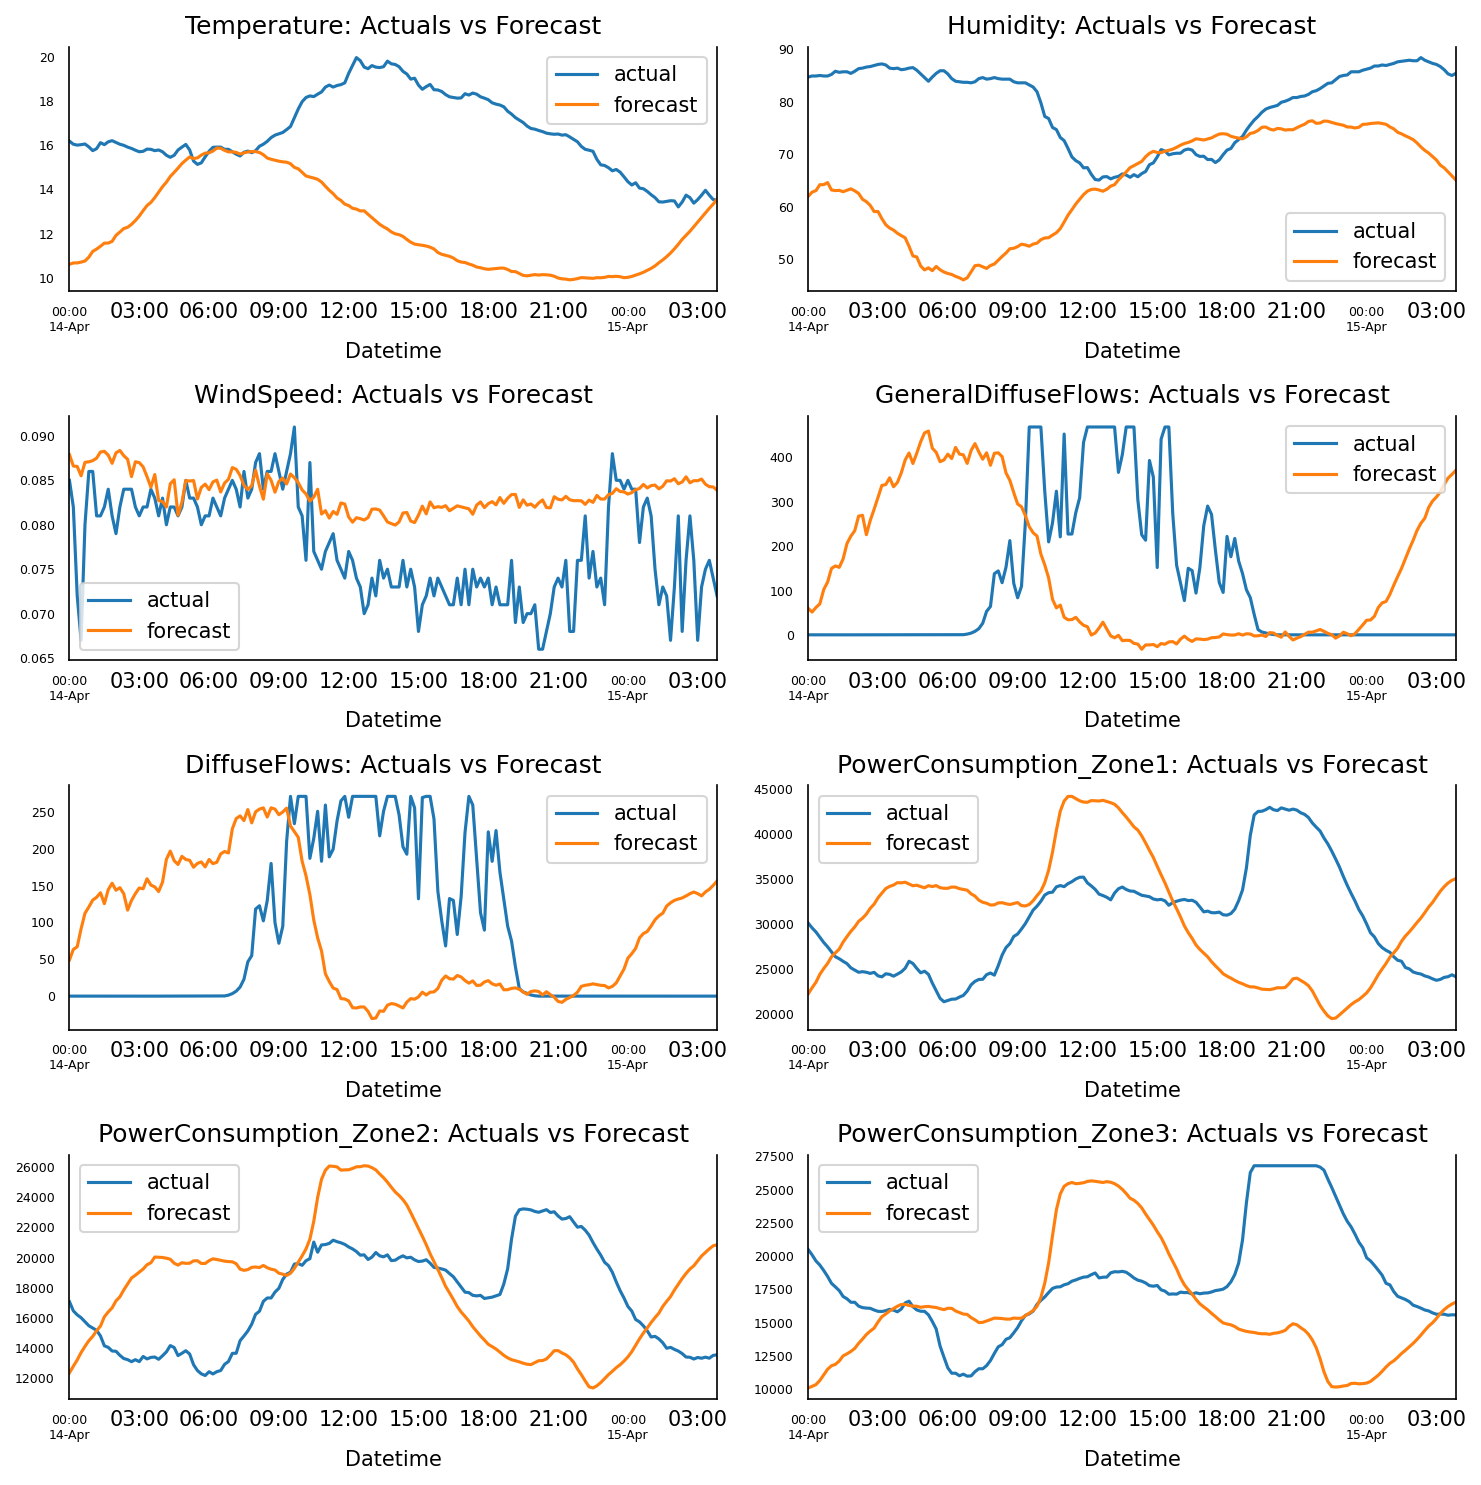

In [1008]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    test[col][-nobs:].plot(legend=True, label='actual', ax=ax)
    df_forecast[col].plot(legend=True, label='forecast', ax=ax)
    ax.set_title(col + ": Actuals vs Forecast")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [1009]:
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                            r2_score)
from math import sqrt

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def validate(name,true, pred):
    print(f"Metrics for {name}")
    print("MSE:", mean_squared_error(true, pred))
    print("RMSE:", sqrt(mean_squared_error(true, pred)))
    print("MAE:", mean_absolute_error(true, pred))
    print("MAPE:", mean_absolute_percentage_error(true, pred))
    print("R2:", r2_score(true, pred),"\n")

def print_metrics(columns, true, pred, nobs):
    for name in columns:
        trueY = true[name][-nobs:]
        predY = pred[name]
        validate(name,trueY,predY)

In [1010]:
print_metrics(df.columns,test,df_forecast,nobs)

Metrics for Temperature
MSE: 24.799269427880198
RMSE: 4.979886487449307
MAE: 4.231965431827963
MAPE: 24.779504104551382
R2: -6.934383619090387 

Metrics for Humidity
MSE: 412.8920298810271
RMSE: 20.3197448281475
MAE: 15.869132691856938
MAPE: 18.990614163635808
R2: -6.267254959710302 

Metrics for WindSpeed
MSE: 6.304014626529548e-05
RMSE: 0.007939782507430255
MAE: 0.006561991168452181
MAPE: 8.915588684407409
R2: -0.8586775311635024 

Metrics for GeneralDiffuseFlows
MSE: 74463.56653480626
RMSE: 272.88013217309583
MAE: 225.05979759335597
MAPE: 311256.26105505164
R2: -1.7986041010244898 

Metrics for DiffuseFlows
MSE: 25203.85096288243
RMSE: 158.75720759348985
MAE: 134.74929036805858
MAPE: 50115.39085387624
R2: -1.2041543712331175 

Metrics for PowerConsumption_Zone1
MSE: 101830455.12334304
RMSE: 10091.107725286805
MAE: 8563.645629340055
MAPE: 27.807636444319293
R2: -1.9095360458135113 

Metrics for PowerConsumption_Zone2
MSE: 30585820.867221624
RMSE: 5530.44490680647
MAE: 4734.4199746840

In [1011]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [1012]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(train)
df_for_testing_scaled = scaler.transform(test)

In [1013]:
def createXY(dataset, n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
        dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
        dataY.append(dataset[i, 0])
    return np.array(dataX), np.array(dataY)

In [1014]:
n_past = 168

trainX,trainY=createXY(df_for_training_scaled,n_past)

testX,testY=createXY(df_for_testing_scaled,n_past)
trainX.shape

(11832, 168, 8)

In [1015]:
testX.shape

(2832, 168, 8)

In [1016]:
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from keras.optimizers import Adam

In [1017]:
from keras.layers import LSTM, Dropout, Dense
from keras.models import Sequential

def build_model(optimizer="adam", npas=168, icol=8):
    grid_model = Sequential()
    grid_model.add(LSTM(20 + npas, return_sequences=True, input_shape=(npas, icol)))
    grid_model.add(LSTM(20 + npas))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))

    grid_model.compile(loss='mse', optimizer=optimizer)

    return grid_model

In [1018]:
#Создание модели
model = KerasRegressor(model=build_model,verbose=1)

# Обучение модели на тренировочных данных
model_fitted = model.fit(trainX, trainY, epochs=5)

Epoch 1/5
370/370 [==============================] - 317s 847ms/step - loss: 0.0035
Epoch 2/5
370/370 [==============================] - 310s 838ms/step - loss: 0.0014
Epoch 3/5
370/370 [==============================] - 311s 842ms/step - loss: 9.9940e-04
Epoch 4/5
370/370 [==============================] - 310s 840ms/step - loss: 8.1959e-04
Epoch 5/5
370/370 [==============================] - 315s 851ms/step - loss: 7.2153e-04


In [1019]:
pred = model_fitted.predict(testX)

89/89 [==============================] - 25s 269ms/step


In [1020]:
cfs = len(df.columns)

pred = pred.reshape(-1, 1)
prediction_copies_array = np.repeat(pred, 8, axis=-1)
prediction=scaler.inverse_transform(np.reshape(prediction_copies_array, (len(prediction_copies_array), cfs)))[:,0]

original_copies_array = np.repeat(testY.reshape(-1, 1), cfs, axis=-1)
original=scaler.inverse_transform(np.reshape(original_copies_array, (len(testY), cfs)))[:,0]

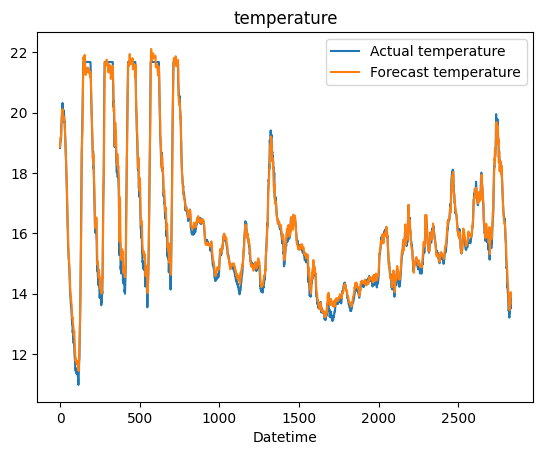

In [1021]:
plt.plot(original, label = 'Actual temperature')
plt.plot(prediction, label = 'Forecast temperature')
plt.title('temperature')
plt.xlabel('Datetime')
plt.legend()
plt.show()

In [1022]:
validate('temperature', original, prediction)

Metrics for temperature
MSE: 0.04947607398996166
RMSE: 0.22243217840492785
MAE: 0.16548807452627498
MAPE: 1.0505945966126407
R2: 0.9908053551077718 

